In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms as tfs
from torchvision.datasets import mnist

import os
import matplotlib.pyplot as plt

### train

In [3]:
train_tf = tfs.Compose([
    tfs.Resize((28, 28)), 
    tfs.RandomInvert(0.7),
    tfs.ToTensor(), 
])

test_tf = tfs.Compose([
    tfs.Resize((28, 28)), 
    tfs.ToTensor(), 
])

train_set = mnist.MNIST('./train_data/', train=True, transform=train_tf, download=True)
test_set = mnist.MNIST('./train_data/', train=False, transform=test_tf, download=True)

train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=64, shuffle=False)

In [4]:
# net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
net = models.resnet18()
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)

In [4]:
optimizer = torch.optim.SGD(net.parameters(), lr=5e-4, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

from utils import train
train(net, train_data, test_data, 10, optimizer, criterion)

Epoch 0. Train Loss: 1.070973, Train Acc: 0.697595, Valid Loss: 0.667049, Valid Acc: 0.835788, Time 00:00:20
Epoch 1. Train Loss: 0.379887, Train Acc: 0.900903, Valid Loss: 0.351396, Valid Acc: 0.909733, Time 00:00:19
Epoch 2. Train Loss: 0.255339, Train Acc: 0.928621, Valid Loss: 0.246837, Valid Acc: 0.931230, Time 00:00:19
Epoch 3. Train Loss: 0.196541, Train Acc: 0.944813, Valid Loss: 0.195542, Valid Acc: 0.943173, Time 00:00:19
Epoch 4. Train Loss: 0.165750, Train Acc: 0.952126, Valid Loss: 0.170635, Valid Acc: 0.951234, Time 00:00:19
Epoch 5. Train Loss: 0.141853, Train Acc: 0.958572, Valid Loss: 0.148904, Valid Acc: 0.955713, Time 00:00:19
Epoch 6. Train Loss: 0.126811, Train Acc: 0.963370, Valid Loss: 0.138604, Valid Acc: 0.959693, Time 00:00:18
Epoch 7. Train Loss: 0.115219, Train Acc: 0.966435, Valid Loss: 0.128502, Valid Acc: 0.960291, Time 00:00:19
Epoch 8. Train Loss: 0.106644, Train Acc: 0.968334, Valid Loss: 0.118536, Valid Acc: 0.964072, Time 00:00:19
Epoch 9. Train Loss

### valid

In [5]:
pic, label = next(iter(test_data))
pic = pic[1].unsqueeze(0)
label = label[1]
print(pic.shape)
print(label)

net.eval()
pic = pic.cuda()
pred = net(pic)
pred_torch = torch.argmax(pred, dim=1)
print(pred_torch)

pred_np = pred.cpu().detach().numpy()
pred_np = np.argmax(pred_np, axis=1)
print(pred_np)


torch.Size([1, 1, 28, 28])
tensor(2)
tensor([2], device='cuda:0')
[2]


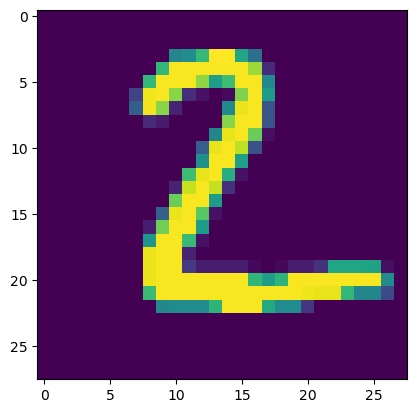

In [6]:
plt.imshow(pic.squeeze().cpu().numpy())

### export to onnx

In [7]:
batch_size = 10

net.cpu().eval()
x = torch.randn(batch_size, 1, 28, 28, requires_grad=True)
torch_out = net(x)

torch.onnx.export(
    net,
    x,
    "./ResNet18-digits.onnx", 
    export_params=True,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### check onnx

In [8]:
import onnx

onnx_model = onnx.load('./ResNet18-digits.onnx')
onnx.checker.check_model(onnx_model)

In [9]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("./ResNet18-digits.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


### reference

https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html